In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
import pickle 
from tqdm import tqdm
import torch

In [2]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

# Datawarrior

### 1. load in original dataset.

In [4]:
exp_original = PandasTools.LoadSDF('../data/dw/00_experimental_training_datasets.sdf')

In [5]:
exp_original.head()

,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x17b40e4a0>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x17b40e200>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x17b40e120>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x17b40e660>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x17b40e7b0>


In [6]:
exp_original.shape

(5994, 7)

### 2. load in "04_experimental_training_dataset" file.

In [7]:
with open('../data/dw/04_experimental_training_dataset.pkl', 'rb') as f:
    raw_exp = pickle.load(f)

In [8]:
len(raw_exp)

5834

In [9]:
raw_exp

{'mol0': {'mols': [(<rdkit.Chem.PropertyMol.PropertyMol at 0x179e56ef0>,
    <rdkit.Chem.PropertyMol.PropertyMol at 0x17b52d400>)],
  'pKa_list': [6.21],
  'smiles_list': [('Brc1c(N2CCCCCC2)nc(C2CC2)[nH+]c1NC1CC1',
    'Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1')],
  'counter_list': [1, 2]},
 'mol1': {'mols': [(<rdkit.Chem.PropertyMol.PropertyMol at 0x17b535db0>,
    <rdkit.Chem.PropertyMol.PropertyMol at 0x17b534310>)],
  'pKa_list': [7.46],
  'smiles_list': [('Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1',
    'Brc1cc(Br)c(NC2=NCCN2)c(Br)c1')],
  'counter_list': [3, 4]},
 'mol2': {'mols': [(<rdkit.Chem.PropertyMol.PropertyMol at 0x17b5341d0>,
    <rdkit.Chem.PropertyMol.PropertyMol at 0x17b534ae0>)],
  'pKa_list': [4.2],
  'smiles_list': [('Brc1cc2cccnc2c2[nH+]cccc12', 'Brc1cc2cccnc2c2ncccc12')],
  'counter_list': [5, 6]},
 'mol3': {'mols': [(<rdkit.Chem.PropertyMol.PropertyMol at 0x17b5346d0>,
    <rdkit.Chem.PropertyMol.PropertyMol at 0x17b534540>)],
  'pKa_list': [3.73],
  'smiles_list': [('Brc1ccc

In [15]:
with open('../data/dw/05_experimental_training_dataset_pyg.pkl', 'rb') as f:
    exp = pickle.load(f)

In [16]:
len(exp)

5834

In [17]:
prot_smiles = []
deprot_smiles = []
prot_charges = []
deprot_charges = []
pka = []
chembl_ids = []
centers = []

for data in tqdm(exp):
    prot_smiles.append(data.smiles_prop)
    deprot_smiles.append(data.smiles_deprop)
    prot_charges.append(data.charge_prot)
    deprot_charges.append(data.charge_deprot)
    pka.append(data.reference_value.item())
    chembl_ids.append(data.chembl_id)
    centers.append(data.reaction_center)


100%|██████████| 5834/5834 [00:00<00:00, 50933.38it/s]


In [61]:
exp_df = pd.DataFrame({'exp_id': chembl_ids,
                          'pka': pka,
                          'center': centers,
                          'prot_smiles': prot_smiles,
                          'deprot_smiles': deprot_smiles,
                          'prot_charge': prot_charges,
                          'deprot_charge': deprot_charges})

In [20]:
exp_df.head()

,exp_id,pka,center,prot_smiles,deprot_smiles,prot_charge,deprot_charge
0,mol0,6.21,10,Brc1c(N2CCCCCC2)nc(C2CC2)[nH+]c1NC1CC1,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,1,0
1,mol1,7.46,9,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,1,0
2,mol2,4.20,9,Brc1cc2cccnc2c2[nH+]cccc12,Brc1cc2cccnc2c2ncccc12,1,0
3,mol3,3.73,8,Brc1ccc(-c2nn[nH]n2)cc1,Brc1ccc(-c2nn[n-]n2)cc1,0,-1
4,mol4,11.00,13,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,Brc1ccc(Br)c(N(CC2CC2)C2=NCCN2)c1,1,0


In [62]:
unstack_mols = []
seen = set()
c = 0
p = []
for id_ in tqdm(exp_df['exp_id']):
    if id_ not in seen:
        seen.add(id_)
        mols = raw_exp[id_]['mols']
        c += len(mols)
        for mol in mols:
            unstack_mols.append([mol[0], mol[1]])
            p.append(mol[0].GetProp('pKa_number'))

100%|██████████| 5834/5834 [00:00<00:00, 155760.90it/s]


In [63]:
len(unstack_mols)

5834

In [65]:
exp_df['prot_mol'] = [mol_with_atom_index(i[0]) for i in unstack_mols]
exp_df['deprot_mol'] = [mol_with_atom_index(i[1]) for i in unstack_mols]

In [66]:
exp_df['acid_base_type'] = exp_df['exp_id'].apply(lambda x: exp_original.loc[int(x.split('mol')[1]), 'marvin_pKa_type'])

,exp_id,pka,center,prot_smiles,deprot_smiles,prot_charge,deprot_charge,prot_mol,deprot_mol,acid_base_type
0,mol0,6.21,10,Brc1c(N2CCCCCC2)nc(C2CC2)[nH+]c1NC1CC1,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,1,0,,,basic
1,mol1,7.46,9,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,1,0,,,basic
2,mol2,4.20,9,Brc1cc2cccnc2c2[nH+]cccc12,Brc1cc2cccnc2c2ncccc12,1,0,,,basic
3,mol3,3.73,8,Brc1ccc(-c2nn[nH]n2)cc1,Brc1ccc(-c2nn[n-]n2)cc1,0,-1,,,acidic
4,mol4,11.00,13,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,Brc1ccc(Br)c(N(CC2CC2)C2=NCCN2)c1,1,0,,,basic

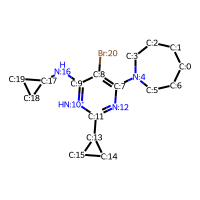
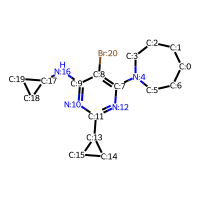
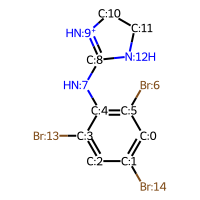
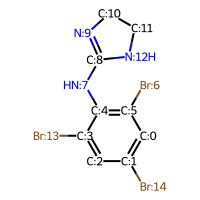
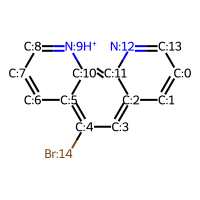
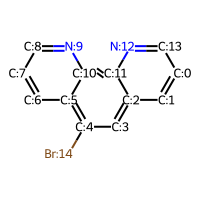
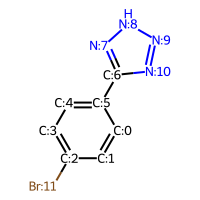
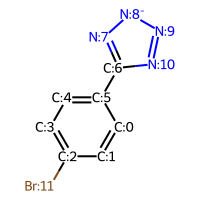
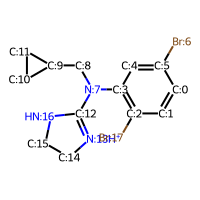
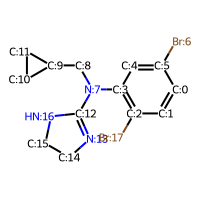

In [67]:
exp_df.head()

In [68]:
exp_df.groupby('acid_base_type').count()

,exp_id,pka,center,prot_smiles,deprot_smiles,prot_charge,deprot_charge,prot_mol,deprot_mol
acid_base_type,,,,,,,,,
acidic,2361,2361,2361,2361,2361,2361,2361,2361,2361
basic,3473,3473,3473,3473,3473,3473,3473,3473,3473


### 3. check if there is conflict between charges on protonated and deprotonated. 

In [69]:
charge_idx = []
for idx, prot_charge, deprot_charge in zip(exp_df.index, exp_df['prot_charge'], exp_df['deprot_charge']):
    
    if prot_charge > deprot_charge:
        continue 
    charge_idx.append(idx)

In [70]:
charge_idx

[57,
 962,
 963,
 964,
 965,
 966,
 967,
 1751,
 1752,
 1753,
 2194,
 2925,
 2926,
 2927,
 4136,
 4137,
 4218,
 5086,
 5087,
 5088,
 5089,
 5090,
 5182,
 5199]

In [71]:
exp_df.loc[charge_idx, ['prot_smiles', 'deprot_smiles']] = exp_df.loc[charge_idx, ['deprot_smiles', 'prot_smiles']].values

In [72]:
exp_df.loc[charge_idx, ['prot_charge', 'deprot_charge']] = exp_df.loc[charge_idx, ['deprot_charge', 'prot_charge']].values

In [73]:
from rdkit.Chem.rdmolops import GetFormalCharge
mol_idx = []
for idx, prot_mol, deprot_mol in zip(exp_df.index, exp_df['prot_mol'], exp_df['deprot_mol']):
    
    if GetFormalCharge(prot_mol) > GetFormalCharge(deprot_mol):
        continue 
    mol_idx.append(idx)

In [74]:
exp_df.loc[mol_idx, ['prot_mol', 'deprot_mol']] = exp_df.loc[mol_idx, ['deprot_mol', 'prot_mol']].values

In [75]:
exp_df.shape

(5834, 10)

### 4. Run acid/basic assignments.

In [36]:
from rdkit.Chem.MolStandardize import rdMolStandardize
un = rdMolStandardize.Uncharger()

from collections import defaultdict

from molvs import standardize_smiles

In [37]:
acid_base_smarts = pd.read_csv('../data/pka_smarts/smarts_pattern.tsv', delimiter='\t')

In [38]:
mol_acid_base = defaultdict(list)
for idx, center, prot_mol, deprot_mol in zip(range(exp_df.shape[0]), exp_df['center'], exp_df['prot_mol'], exp_df['deprot_mol']):
    #p = Chem.MolFromSmiles(standardize_smiles(Chem.MolToSmiles(mol_with_atom_index(deprot_mol))))
    #mol = Chem.MolFromSmiles(smi)
    #p = deprot_mol
    prot_mol = un.uncharge(prot_mol)
    #mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol_with_atom_index(mol)))
    mol = Chem.AddHs(prot_mol)
    for smart, a in zip(acid_base_smarts['    SMARTS'], acid_base_smarts['Acid_or_base']):
        if mol.HasSubstructMatch(Chem.MolFromSmarts(smart)):
            matches = sum(mol.GetSubstructMatches(Chem.MolFromSmarts(smart)), ())
            #print(smart, matches)
            center = int(center)
            if center in matches:
                #print('here')
                if deprot_mol.GetAtomWithIdx(center).GetFormalCharge() == -1: 
                    if a == 'A':
                        mol_acid_base[idx].append([smart, a])
                        break
                elif deprot_mol.GetAtomWithIdx(center).GetFormalCharge() == 0:
                    if a == 'B':
                        mol_acid_base[idx].append([smart, a])
                        break
                        

In [39]:
len(mol_acid_base)

5511

In [76]:
c = 0 
use_i = []
for i in list(mol_acid_base.keys()):
    if exp_df.loc[i, 'acid_base_type'] == 'acidic' and mol_acid_base[i][0][1] == 'A':
        c += 1
        use_i.append(i)
    elif exp_df.loc[i, 'acid_base_type'] == 'basic' and mol_acid_base[i][0][1] == 'B':
        c += 1
        use_i.append(i)
        

In [77]:
c

5325

In [78]:
not_use_i = set(list(mol_acid_base.keys())) - set(use_i)

In [79]:
len(not_use_i)

186

In [80]:
acid_base_check = exp_df.iloc[list(not_use_i), :]

In [81]:
idx = []
for idx_, center, prot_mol in zip(acid_base_check.index, acid_base_check['center'], acid_base_check['prot_mol']):
    if prot_mol.GetAtomWithIdx(int(center)).GetFormalCharge() == 1 and acid_base_check.loc[idx_, 'acid_base_type'] == 'acidic':
        idx.append(idx_)
        print(idx_, acid_base_check.loc[idx_, 'acid_base_type'])

5130 acidic
1037 acidic
2573 acidic
2065 acidic
1561 acidic
2077 acidic
4637 acidic
5665 acidic
556 acidic
4653 acidic
5180 acidic
4174 acidic
1103 acidic
1107 acidic
1109 acidic
4185 acidic
4186 acidic
4187 acidic
4188 acidic
4189 acidic
2655 acidic
2656 acidic
1634 acidic
1635 acidic
1636 acidic
1637 acidic
1128 acidic
2665 acidic
2666 acidic
2667 acidic
2668 acidic
1646 acidic
2669 acidic
2160 acidic
2161 acidic
2670 acidic
4034 acidic
4206 acidic
4207 acidic
4213 acidic
4216 acidic
4217 acidic
5245 acidic
5246 acidic
5248 acidic
4225 acidic
5249 acidic
4233 acidic
5258 acidic
5261 acidic
2193 acidic
5268 acidic
5269 acidic
2721 acidic
5288 acidic
2733 acidic
2734 acidic
2735 acidic
2736 acidic
2737 acidic
2738 acidic
4273 acidic
2744 acidic
3773 acidic
5318 acidic
1736 acidic
1738 acidic
1741 acidic
1742 acidic
3816 acidic
2794 acidic
3307 acidic
2303 acidic
4358 acidic
4359 acidic
264 acidic
265 acidic
4361 acidic
2316 acidic
2317 acidic
2318 acidic
2319 acidic
4362 acidic
2322 ac

In [82]:
len(idx)

157

In [83]:
idx1 = []
for idx_, center, prot_mol in zip(acid_base_check.index, acid_base_check['center'], acid_base_check['prot_mol']):
    if prot_mol.GetAtomWithIdx(int(center)).GetFormalCharge() == 0 and acid_base_check.loc[idx_, 'acid_base_type'] == 'basic':
        idx1.append(idx_)
        print(idx_, acid_base_check.loc[idx_, 'acid_base_type'])

514 basic
5658 basic
3621 basic
603 basic
619 basic
3189 basic
5235 basic
637 basic
4240 basic
4241 basic
4242 basic
691 basic
4343 basic
249 basic
3339 basic
1317 basic
3375 basic
2885 basic
1362 basic
863 basic
357 basic
358 basic
878 basic
2429 basic
1437 basic
976 basic
986 basic
481 basic
482 basic


In [84]:
len(idx1)

29

In [85]:
exp_df['acid_base_string'] = str

In [86]:
exp_df.loc[list(mol_acid_base.keys()), 'acid_base_string'] = [i[0][1] for i in list(mol_acid_base.values())]

In [87]:
not_use_i1 = set(exp_df.index) - set(list(mol_acid_base.keys()))

In [88]:
len(not_use_i1)

323

In [89]:
res = []
#check2 = []
for i in not_use_i1:
    print(i)
    prot_mol = exp_df.loc[i, 'prot_mol']
    deprot_mol = exp_df.loc[i, 'deprot_mol']
    prot_charge = exp_df.loc[i, 'prot_charge']
    deprot_charge = exp_df.loc[i, 'deprot_charge']
    center = int(exp_df.loc[i, 'center'])

    if prot_mol.GetAtomWithIdx(center).GetFormalCharge() == 0 and deprot_mol.GetAtomWithIdx(center).GetFormalCharge() == -1: 
        #if prot_charge != 0 or deprot_charge != -1:
        #    check2.append(i)
        res.append('A')
    
    if prot_mol.GetAtomWithIdx(center).GetFormalCharge() == 1 and deprot_mol.GetAtomWithIdx(center).GetFormalCharge() == 0: 
        #if prot_charge != 1 or deprot_charge != 0:
        #    check2.append(i)
        res.append('B')

2063
2071
2072
4136
4137
2090
2091
2092
4138
2094
2095
4139
4141
2101
2104
57
4156
4163
80
4179
4180
4181
2144
2146
2147
4201
2155
2159
114
4218
124
125
126
4231
4232
4235
4236
4237
4238
4239
2194
2229
205
2253
2255
2267
2268
2269
2270
2271
2272
4337
4340
248
269
2321
281
2331
290
4423
2379
360
2420
2430
425
2493
452
2520
4582
2537
2538
500
501
502
505
4613
2574
2575
4625
4627
2586
2589
4654
2608
2629
588
606
4706
625
626
627
628
2681
4739
2695
4743
4744
671
672
2730
2731
2740
2748
2752
2753
2755
2760
2793
2821
2852
812
820
2925
2926
2927
2936
895
954
955
959
960
5068
5086
5087
3040
5088
5089
5090
3045
3046
3047
3056
1016
1017
5123
1032
5132
5139
5140
5141
5182
5187
5190
5192
3145
5193
5194
3148
5197
1102
5196
5200
3152
3153
3154
3155
3157
5198
3159
3160
3161
3162
5208
3164
3165
3167
5216
5217
5218
3171
5219
5222
5225
5233
5238
3191
5240
5241
1155
5281
5282
3236
5289
5291
5292
5293
3249
3250
1203
1204
5299
5300
5301
5313
5315
5316
3273
3274
3275
1229
3278
3279
3280
5332
5338
5339
5342


In [90]:
len(res)

323

In [91]:
exp_df.loc[list(not_use_i1), 'acid_base_string'] = res

,exp_id,pka,center,prot_smiles,deprot_smiles,prot_charge,deprot_charge,prot_mol,deprot_mol,acid_base_type,acid_base_string
0,mol0,6.21,10,Brc1c(N2CCCCCC2)nc(C2CC2)[nH+]c1NC1CC1,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,1,0,,,basic,B
1,mol1,7.46,9,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,1,0,,,basic,B
2,mol2,4.20,9,Brc1cc2cccnc2c2[nH+]cccc12,Brc1cc2cccnc2c2ncccc12,1,0,,,basic,B
3,mol3,3.73,8,Brc1ccc(-c2nn[nH]n2)cc1,Brc1ccc(-c2nn[n-]n2)cc1,0,-1,,,acidic,A
4,mol4,11.00,13,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,Brc1ccc(Br)c(N(CC2CC2)C2=NCCN2)c1,1,0,,,basic,B

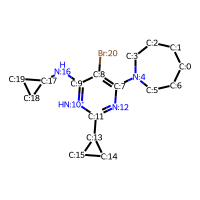
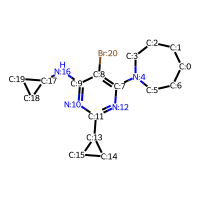
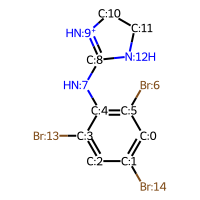
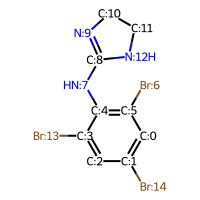
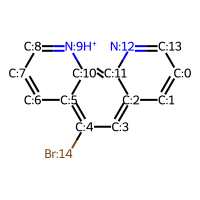
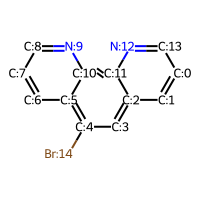
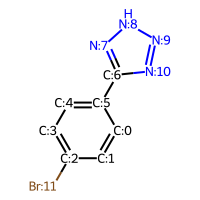
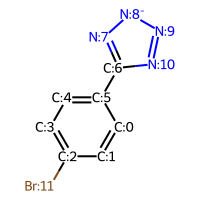
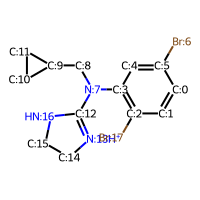
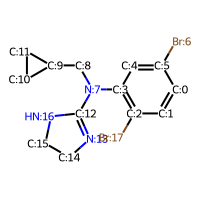

In [92]:
exp_df.head()

In [93]:
exp_df.groupby('acid_base_string').count()

,exp_id,pka,center,prot_smiles,deprot_smiles,prot_charge,deprot_charge,prot_mol,deprot_mol,acid_base_type
acid_base_string,,,,,,,,,,
A,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070
B,3764,3764,3764,3764,3764,3764,3764,3764,3764,3764


In [94]:
ROMol = []
#acid_base_num = []
for i in exp_df.index:
    acid_base = exp_df.loc[i, 'acid_base_string']
    #acid_base_string.append(acid_base)
    if acid_base == 'A':
        ROMol.append(exp_df.loc[i, 'prot_mol'])
    elif acid_base == 'B':
        ROMol.append(exp_df.loc[i, 'deprot_mol'])

In [95]:
len(ROMol)

5834

In [96]:
exp_df['ROMol'] = ROMol

In [97]:
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomCount, NumHAcceptors, NumHDonors, MolLogP, NumRotatableBonds

In [98]:
mw, hac, nhd, nha, logp, nrb = [], [], [], [], [], []
for mol in tqdm(exp_df['ROMol']):
    mw.append(ExactMolWt(mol))
    hac.append(HeavyAtomCount(mol))
    nhd.append(NumHDonors(mol))
    nha.append(NumHAcceptors(mol))
    logp.append(MolLogP(mol))
    nrb.append(NumRotatableBonds(mol))

100%|██████████| 5834/5834 [00:01<00:00, 3226.04it/s]


In [99]:
for i,j in zip(['MolWt', 'HeavyAtomCount', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 'NumRotatableBonds'], [mw, hac, nhd, nha, logp, nrb]):
    exp_df[i] = j

In [100]:
exp_df[['MolWt', 'HeavyAtomCount', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 'NumRotatableBonds']].describe()

,MolWt,HeavyAtomCount,NumHDonors,NumHAcceptors,MolLogP,NumRotatableBonds
count,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000
mean,242.832501,16.928351,1.117758,3.032396,2.215666,3.079534
std,112.164356,7.966349,0.904690,1.881127,1.646960,2.806433
min,27.010899,2.000000,0.000000,0.000000,-5.018800,0.000000
25%,152.047344,11.000000,1.000000,2.000000,1.135390,1.000000
50%,214.049075,15.000000,1.000000,3.000000,2.125360,2.000000
75%,318.148033,22.000000,1.000000,4.000000,3.321643,4.000000
max,717.280790,50.000000,6.000000,12.000000,10.758400,28.000000


In [101]:
torch.save(exp_df, '../data/dw/exp_processed.pt')